# Module 8 Final Project - Chatham

In [43]:
import cdsapi
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import pandas as pd
from eofs.xarray import Eof
import scipy.stats as stats

Create a dataset that contains the monthly means of Sea Surface Temperature anomalies from Jan 2003-Dec 2020 over the intended region (60°N to 60°S, 0-360) masked out over land. The data and land sea mask is available here: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download

In [ ]:
# dataset = "reanalysis-era5-single-levels-monthly-means"
# request = {
#     "product_type": ["monthly_averaged_reanalysis"],
#     "year": [
#         "2003", "2004", "2005",
#         "2006", "2007", "2008",
#         "2009", "2010", "2011",
#         "2012", "2013", "2014",
#         "2015", "2016", "2017",
#         "2018", "2019", "2020"
#     ],
#     "month": [
#         "01", "02", "03",
#         "04", "05", "06",
#         "07", "08", "09",
#         "10", "11", "12"
#     ],
#     "time": ["00:00"],
#     "data_format": "netcdf",
#     "download_format": "unarchived",
#     "variable": [
#         "land_sea_mask",
#         "sea_surface_temperature"
#     ],
#     "area": [60, 0, -60, 360]
# }

# client = cdsapi.Client()
# client.retrieve(dataset, request).download()

2025-12-06 16:46:55,278 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-12-06 16:46:55,821 INFO Request ID is 1854dcff-a2cd-4e17-b84f-50316cc3e756
2025-12-06 16:46:56,003 INFO status has been updated to accepted
2025-12-06 16:47:04,839 INFO status has been updated to running
2025-12-06 16:48:51,322 INFO status has been updated to successful


76e23a1f04c9a2ad624fbf395be80a3.nc:   0%|          | 0.00/268M [00:00<?, ?B/s]

'76e23a1f04c9a2ad624fbf395be80a3.nc'

In [44]:
ds = xr.open_dataset("76e23a1f04c9a2ad624fbf395be80a3.nc")
ds

<xarray.Dataset> Size: 1GB
Dimensions:     (valid_time: 216, latitude: 481, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 2kB 2003-01-01 ... 2020-12-01
  * latitude    (latitude) float64 4kB 60.0 59.75 59.5 ... -59.5 -59.75 -60.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 3kB ...
Data variables:
    lsm         (valid_time, latitude, longitude) float32 598MB ...
    sst         (valid_time, latitude, longitude) float32 598MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-06T22:48 GRIB to CDM+CF via cfgrib-0.9.1...

In [45]:
# Apply mask: keep ocean only (0 aka where lsm < 0.5)
# Extract static mask (remove time)
mask_static = ds["lsm"].isel(valid_time=0)

# Interpolate mask to SST grid (even if it looks identical)
mask_interp = mask_static.interp_like(ds["sst"])

# Apply ocean mask and verify
ds_ocean = ds.where(mask_interp < 0.5)
print("Valid ocean SST points:", int(np.isfinite(ds_ocean["sst"]).sum()))

Valid ocean SST points: 109556496


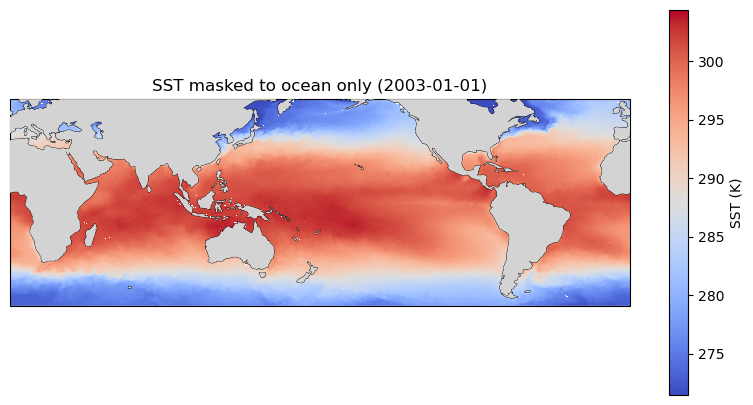

In [46]:
# testing data to see if it makes sense visually
var = "sst" 
da = ds_ocean[var].isel(valid_time=0)  # first month

plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
p = ax.pcolormesh(da.longitude, da.latitude, da, cmap="coolwarm", transform=ccrs.PlateCarree())

# add coastlines & land for reference
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=100)

# focus on extent of data
ax.set_extent([0, 360, -60, 60], crs=ccrs.PlateCarree())

# colorbar and title
plt.colorbar(p, label=f"{var.upper()} ({da.attrs.get('units','')})")
plt.title(f"{var.upper()} masked to ocean only ({str(da.valid_time.values)[:10]})")
plt.show()

Compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data. Then, standardize.

In [47]:
# From Professor

def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z

In [ ]:
# dataset2 = "cams-global-ghg-reanalysis-egg4-monthly"
# request2 = {
#     "variable": ["co2_column_mean_molar_fraction"],
#     "year": [
#         "2003", "2004", "2005",
#         "2006", "2007", "2008",
#         "2009", "2010", "2011",
#         "2012", "2013", "2014",
#         "2015", "2016", "2017",
#         "2018", "2019", "2020"
#     ],
#     "month": [
#         "01", "02", "03",
#         "04", "05", "06",
#         "07", "08", "09",
#         "10", "11", "12"
#     ],
#     "product_type": ["monthly_mean"],
#     "data_format": "netcdf_zip",
#     "area": [60, 0, -60, 360]
# }

# client2 = cdsapi.Client()
# client2.retrieve(dataset2, request2).download()

# import zipfile
# import os

# zip_path = "790fd11f889b96fe88afddd2cc776696.zip"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall()

2025-12-07 14:49:55,828 INFO [2025-12-03T00:00:00Z] To improve our CAMS service, we need to hear from you! Please complete this very short [survey]( https://confluence.ecmwf.int/x/CruBEQ/). Thank you.
2025-12-07 14:49:56,255 INFO Request ID is 1342831c-3483-436e-bc58-c9d4fbabb2d9
2025-12-07 14:49:56,442 INFO status has been updated to accepted
2025-12-07 14:50:10,782 INFO status has been updated to successful


790fd11f889b96fe88afddd2cc776696.zip:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

In [48]:
ds_co2 = xr.open_dataset("data_allhours_sfc.nc")
ds_co2

<xarray.Dataset> Size: 67MB
Dimensions:     (valid_time: 216, latitude: 161, longitude: 480)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 2003-01-01 ... 2020-12-01
  * latitude    (latitude) float64 1kB 60.0 59.25 58.5 ... -58.5 -59.25 -60.0
  * longitude   (longitude) float64 4kB 0.0 0.75 1.5 2.25 ... 357.8 358.5 359.2
Data variables:
    tcco2       (valid_time, latitude, longitude) float32 67MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-04T19:22 GRIB to CDM+CF via cfgrib-0.9.1...

I’m using total column CO₂ because ENSO affects the whole Earth system, not just surface CO₂. Total column values give a cleaner, more global signal of how the carbon cycle responds. It’s the best way to see ENSO’s fingerprint without local noise.

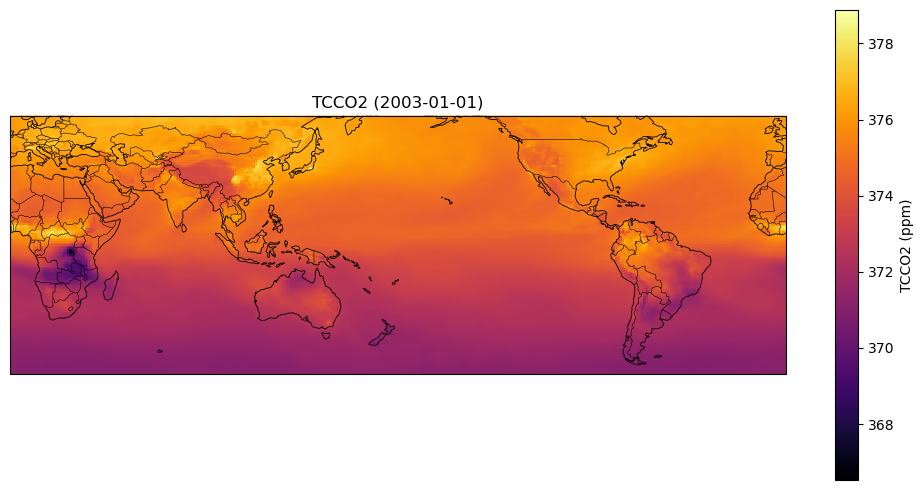

In [ ]:
var = "tcco2" # CO2 column-mean molar fraction
da = ds_co2[var].isel(valid_time=0)  # first month (2003-01-01)

plt.figure(figsize=(10, 5))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# pcolormesh over lon/lat
p = ax.pcolormesh(da.longitude, da.latitude, da, cmap="inferno", transform=ccrs.PlateCarree())

# coastlines / land for reference
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)

ax.set_extent([0, 360, -60, 60], crs=ccrs.PlateCarree())

units = da.attrs.get("units", "")
plt.colorbar(p, label=f"{var.upper()} ({units})")

time_str = str(da.valid_time.values)[:10]
plt.title(f"{var.upper()} ({time_str})")

plt.tight_layout()
plt.show()

# atmospheric CO₂ is highest over the Northern Hemisphere during winter and lower over the Southern Ocean
# reflecting both human emissions and natural carbon-cycle processes

To relate CO2 variability to SST variability / ENSO, I need to deseasonalize fields (remove the strong annual cycle), detrend fields (remove long-term rising CO2 trend, and any slow SST trend), and observe anomalies that are comparable in time.

If I were to only do this for SST but leave CO2 as raw, trending values, then any correlation / EOF I would compute would be dominated by the long-term CO2 increase, not ENSO-like variability. To study shared interannual variability, I want SST anomalies and CO2 anomalies treated in a consistent way.

In [52]:
# Merge SST and CO2 onto the same time grid
combined = xr.merge([ds_ocean[["sst"]], ds_co2[["tcco2"]]])
combined = combined.chunk({"valid_time": -1})

C:\Users\aliso\AppData\Local\Temp\ipykernel_9044\2839333856.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'latitude' ('latitude',) The recommendation is to set join explicitly for this case.
  combined = xr.merge([ds_ocean[["sst"]], ds_co2[["tcco2"]]])
C:\Users\aliso\AppData\Local\Temp\ipykernel_9044\2839333856.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'longitude' ('longitude',) The recommendation is to set join explicitly for this case.
  combined = xr.merge([ds_ocean[["sst"]], ds_co2[["tcco2"]]]

In [53]:
# Detrend 
detr = linear_detrend(combined, time_dim="valid_time")

# Deseasonalize and compute anomalies / standardized anomalies
anom, z = monthly_anom_and_z(detr, time_dim="valid_time", base_period=None) # monthly standardized anomalies by month (z-scores per calendar month)

print("Variables in anomaly set:", list(anom.data_vars))
print("Variables in z-score set:", list(z.data_vars))

Variables in anomaly set: ['sst', 'tcco2']
Variables in z-score set: ['sst', 'tcco2']


In [54]:
# in comparison, standardizes across the full time dimension, not month-by-month
# Standardize SST anomalies
sst_anom = anom["sst"]
sst_standardized = (sst_anom - sst_anom.mean(dim="valid_time")) / sst_anom.std(dim="valid_time")
sst_standardized.name = "sst_standardized"

# Standardize CO₂ anomalies
co2_anom = anom["tcco2"] 
co2_standardized = (co2_anom - co2_anom.mean(dim="valid_time")) / co2_anom.std(dim="valid_time")
co2_standardized.name = "co2_standardized"

# std_ds = xr.Dataset(
#     {
#         "sst_standardized": sst_standardized,
#         "co2_standardized": co2_standardized,
#     }
# )

In [55]:
# Load into memory for validation 
sst_standardized_local = sst_standardized.compute()
co2_standardized_local = co2_standardized.compute()

# Check SST
print("SST has valid data:", np.isfinite(sst_standardized_local).any().item())
print("SST mean ~ 0:", float(sst_standardized_local.mean("valid_time", skipna=True).mean()))
print("SST std ~ 1:",  float(sst_standardized_local.std("valid_time",  skipna=True).mean()))

# Check CO2
print("CO2 has valid data:", np.isfinite(co2_standardized_local).any().item())
print("CO2 mean ~ 0:", float(co2_standardized_local.mean("valid_time", skipna=True).mean()))
print("CO2 std ~ 1:",  float(co2_standardized_local.std("valid_time",  skipna=True).mean()))

SST has valid data: True
SST mean ~ 0: -5.0147944824496804e-11


c:\Users\aliso\anaconda3\envs\xarray-climate\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


SST std ~ 1: 1.0
CO2 has valid data: True
CO2 mean ~ 0: -6.588743439728262e-11
CO2 std ~ 1: 1.0


c:\Users\aliso\anaconda3\envs\xarray-climate\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


EOF analysis on deseasonalized CO₂ anomalies
- May coarsen spatially to resolve compute issues

In [ ]:
co2_da = co2_anom
if "valid_time" in co2_da.dims:
    co2_da = co2_da.rename({"valid_time": "time"})

# cropped space to pacific 
co2_da = co2_da.sel(longitude=slice(120, 300), latitude=slice(-60, 60))

print("Original:", co2_da.shape)
# print("Coarsened:", co2_small.shape)

# chunk for dask
# co2_small = co2_small.chunk({"time": -1, "latitude": 40, "longitude": 60})

# EOFs
solver_co2 = Eof(co2_da)
co2_eofs = solver_co2.eofs(neofs=5)
co2_pcs  = solver_co2.pcs(npcs=5, pcscaling=1)
co2_var  = solver_co2.varianceFraction(neigs=5)

Original: (216, 481, 721)


First EOF spatial pattern

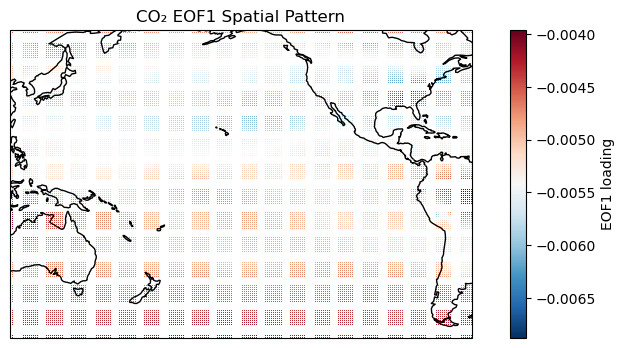

In [57]:
# Plot the first CO2 EOF spatial pattern
plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
co2_eofs.isel(mode=0).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    cbar_kwargs={"label": "EOF1 loading"}
)
ax.coastlines()
ax.set_title("CO₂ EOF1 Spatial Pattern")
plt.show()

To answer a couple of questions:
- The field was aggressively coarsened + subset too tightly
- Total column CO₂ varies very little spatially. Even before anomalies, total-column CO₂ only varies by 1–4 ppm spatially over a baseline near 375 ppm. Anomalies are extremely small: around 0.1 ppm after detrending and 0.01 ppm after deseasonalizing. (EOFs may work better when the field has significant variability.)

This is NOT a meaningful EOF1 pattern.

In [ ]:
# Get CO2 anomaly DataArray
co2_da = co2_anom
if isinstance(co2_anom, xr.Dataset):
    co2_da = co2_anom["tcco2"]
if "valid_time" in co2_da.dims:
    co2_da = co2_da.rename({"valid_time": "time"})
print("Full anomaly shape:", co2_da.shape)

# Subset to 60S–60N and Pacific 120E–300E
co2_da = co2_da.sel(latitude=slice(-60, 60), longitude=slice(120, 300))
print("After spatial subsetting:", co2_da.shape)

# Quick finite check for dask
has_finite = bool(np.isfinite(co2_da).any().compute())
print("Any finite values:", has_finite)

# Rechunk for smooth coarsening: one chunk along lat/lon
co2_da = co2_da.chunk({
    "time": -1,
    "latitude": co2_da.sizes["latitude"],
    "longitude": co2_da.sizes["longitude"],
})

# Moderately coarsen to reduce resolution but keep structure
coarsen_lat = 4
coarsen_lon = 4
co2_small = co2_da.coarsen(latitude=coarsen_lat, longitude=coarsen_lon, boundary="trim").mean()
print("Coarsened shape:", co2_small.shape)
co2_small = co2_small.compute()

# EOF analysis
solver_co2 = Eof(co2_small, center=True)
co2_eofs = solver_co2.eofs(neofs=5)             
co2_pcs  = solver_co2.pcs(npcs=5, pcscaling=1)  
co2_var  = solver_co2.varianceFraction(neigs=5)  
print("Variance fraction of first 5 modes:", co2_var.values)

Full anomaly shape: (216, 481, 1440)
After spatial subsetting: (216, 481, 721)
Any finite values?: True
Coarsened shape: (216, 120, 180)
Variance fraction of first 5 modes: [0.90446806 0.02485723 0.01315894 0.00759926 0.00576174]


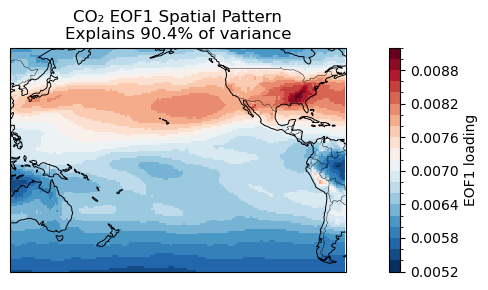

In [ ]:
eof1 = co2_eofs.isel(mode=0)

plt.figure(figsize=(9, 3))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
eof1.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=21,cbar_kwargs={"label": "EOF1 loading"})
ax.coastlines(linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.set_extent([120, 300, -60, 60], crs=ccrs.PlateCarree())
ax.set_title(f"CO₂ EOF1 Spatial Pattern\nExplains {float(co2_var.isel(mode=0)*100):.1f}% of variance")
plt.tight_layout()
plt.show()

- when the PC1 time series is positive, the red regions have above-normal CO2 (after removing the long-term trend and seasonal cycle)
- blue areas means CO2 anomalies there decrease when PC1 increases
- seemingly, CO2 anomalies are strongly influenced by ENSO
- matches research from Agusti-Panareda et al., CAMS GHG reanalysis!
"This structure reflects how ENSO modulates ocean–atmosphere CO₂ exchange—El Niño events suppress ocean uptake and raise CO₂ in the tropics, while La Niña enhances uptake and lowers CO₂ concentrations."

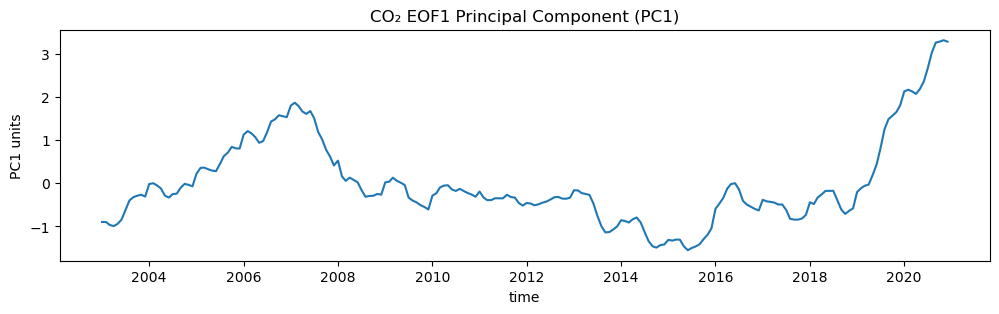

In [64]:
# Plot the PC1 time series
co2_pcs.isel(mode=0).plot(figsize=(12,3))
plt.title("CO₂ EOF1 Principal Component (PC1)")
plt.ylabel("PC1 units")
plt.show()

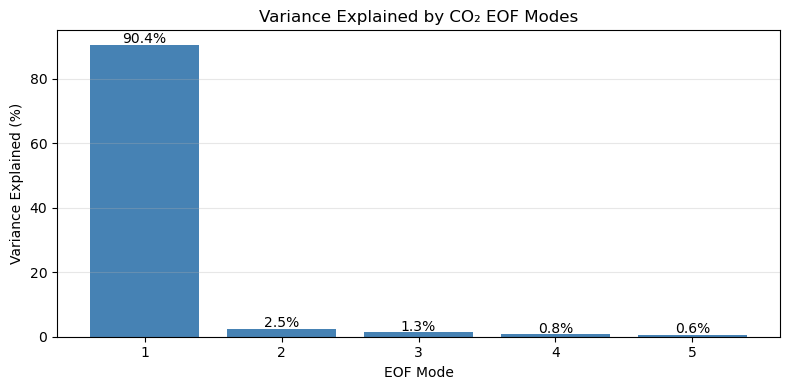

In [ ]:
# variance explained bar chart
var_pct = co2_var.values * 100

plt.figure(figsize=(8,4))
plt.bar(range(1, len(var_pct)+1), var_pct, color='steelblue')

plt.xlabel("EOF Mode")
plt.ylabel("Variance Explained (%)")
plt.title("Variance Explained by CO₂ EOF Modes")
plt.xticks(range(1, len(var_pct)+1))
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(var_pct):
    plt.text(i+1, v + 0.5, f"{v:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

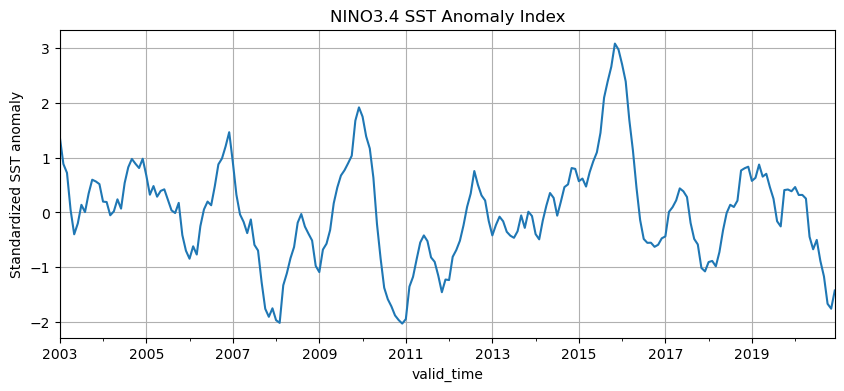

In [67]:
nino34_da = (sst_standardized.sel(latitude=slice(-5, 5), longitude=slice(190, 240)).mean(dim=["latitude", "longitude"]))
nino34 = nino34_da.to_series()
nino34.name = "ENSO_NINO34"
plt.figure(figsize=(10,4))
nino34.plot()
plt.title("NINO3.4 SST Anomaly Index")
plt.ylabel("Standardized SST anomaly")
plt.grid(True)
plt.show()

In [69]:
pc1 = co2_pcs.isel(mode=0).to_series()
enso_pc1_aligned = pd.concat([nino34, pc1], axis=1).dropna()
enso = enso_pc1_aligned.iloc[:, 0]
pc1  = enso_pc1_aligned.iloc[:, 1]

r, p = pearsonr(enso, pc1)
print("Correlation r:", r)
print("p-value:", p)

Correlation r: -0.2493799
p-value: 0.00021346662473686296


Breaking it down:
- When ENSO is positive (El Nino)...CO2 PC1 tends to decrease
- When ENSO is negative (La Nina)...CO2 PC1 tends to increase
- r is moderately weak, but not nothing
- small p value indicating statistical significance, not randomness
- consistent with known ENSO–carbon cycle interactions

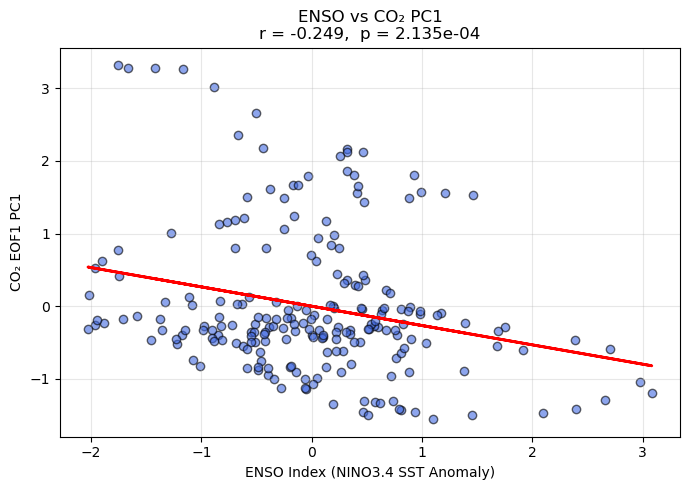

In [70]:
plt.figure(figsize=(7,5))
plt.scatter(enso, pc1, alpha=0.6, color="royalblue", edgecolor="k")

# Add least-squares trend line
m, b = np.polyfit(enso, pc1, 1)
plt.plot(enso, m*enso + b, color="red", linewidth=2)

plt.xlabel("ENSO Index (NINO3.4 SST Anomaly)")
plt.ylabel("CO₂ EOF1 PC1")
plt.title(f"ENSO vs CO₂ PC1\nr = {r:.3f},  p = {p:.3e}")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Final Words:
Even though global CO2 almost always increases year-to-year, the spatial pattern captured by EOF1 responds in a consistent way to ENSO.
ENSO does influence the dominant mode of CO2 variability, but highly likely it doesn’t explain everything as we know that many other processes also modulate CO2.